# Peak-Valley Method

In [1]:
import copy
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

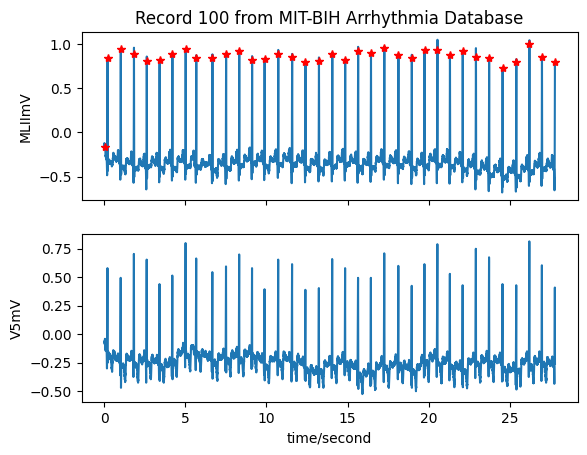

{'record_name': '100',
 'extension': 'atr',
 'sample': array([  18,   77,  370,  662,  946, 1231, 1515, 1809, 2044, 2402, 2706,
        2998, 3282, 3560, 3862, 4170, 4466, 4764, 5060, 5346, 5633, 5918,
        6214, 6527, 6823, 7106, 7391, 7670, 7953, 8245, 8539, 8837, 9141,
        9431, 9710, 9998], dtype=int64),
 'symbol': ['+',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'A',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'],
 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'chan': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'num': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'aux_note': ['(

In [2]:
# Extract data from files

# Samples from the original data to load
SAMPLE_NUM = 10000

record = wfdb.rdrecord('../src/mitdb/100', sampto = SAMPLE_NUM)
annotation = wfdb.rdann('../src/mitdb/100', 'atr', sampto = SAMPLE_NUM)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 100 from MIT-BIH Arrhythmia Database',
               time_units='seconds')
#display(record.__dict__)
display(annotation.__dict__)


In [3]:
# Sampling frequency
FREQ_SAMPLE = 360

# Extract ECG data array
v_data = record.p_signal
v_data = v_data[:,0]

# Define time array (Fs:360Hz)
v_time = np.arange(0, v_data.size, 1, dtype=int)
v_time = np.round(v_time/FREQ_SAMPLE, 3)

# Extract annotations array
v_ann = np.zeros(shape=(v_data.size,1), dtype=str)
for i in range(len(annotation.sample)):
    v_ann[(annotation.sample)[i]] = annotation.symbol[i]


In [4]:
# Calculate moving averages

# Window size for moving averages
MEAN_WINDOW = 50
LOWPASS_WINDOW = 5

v_mean = np.zeros_like(v_data)
v_data_lp = np.zeros_like(v_data)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

tmp_mean = moving_average(v_data,MEAN_WINDOW)
tmp_lowpass = moving_average(v_data, LOWPASS_WINDOW)

v_mean = np.pad(tmp_mean, (MEAN_WINDOW-1,0), 'constant', constant_values=(tmp_mean[0],0))
v_data_lp = np.pad(tmp_lowpass, (LOWPASS_WINDOW-1,0), 'constant', constant_values=(tmp_lowpass[0],0))

In [5]:
# Identify potential peaks
# Compare 3 signal samples S0, S1, S2
# Peak if:  S1>S0 and S1>S2
#           S1<S0 and S1<S2

DELTA_PEAK = 0.04
DELTA_TIME = 75/FREQ_SAMPLE     # SNumber of samples / Sampling frequency

v_peaks_data = np.zeros_like(v_data_lp)
v_peaks_time = np.zeros_like(v_data_lp)
j = 0

# Walk through all samples
for i in range(1, len(v_data_lp)-1):
    # Identify peak
    if  ((v_data_lp[i] >= v_data_lp[i-1]) and (v_data_lp[i] > v_data_lp[i+1])) or \
        ((v_data_lp[i] <= v_data_lp[i-1]) and (v_data_lp[i] < v_data_lp[i+1])):
        # Check if peak value big enough
        if  (abs(v_data_lp[i] - v_peaks_data[j-1]) > DELTA_PEAK) or \
            (abs(v_time[i] - v_peaks_time[j-1]) > DELTA_TIME):
            v_peaks_data[j] = v_data_lp[i]
            v_peaks_time[j] = v_time[i]
            j += 1

v_peaks_data = v_peaks_data[v_peaks_time != 0]
v_peaks_time = v_peaks_time[v_peaks_time != 0]

In [6]:
# Zeros array for x-axis

axis_x = np.zeros_like(v_data)

In [7]:
# Time array for evenly spaced peaks

TIMESTEP = 0.05

v_time_even = np.arange(0, len(v_peaks_data)*TIMESTEP, TIMESTEP)

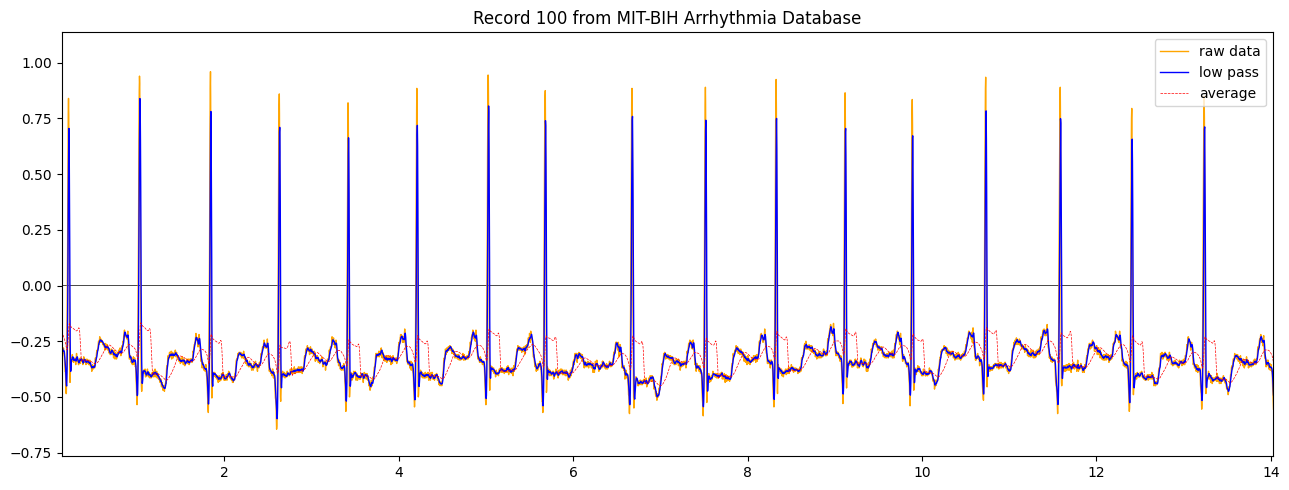

In [8]:
# Plot results

# Number of samples to plot (PLOT_SIZE+MEAN_WINDOW < SAMPLE_NUM)
PLOT_SIZE = 5000

plt.rcParams["figure.figsize"] = (13,5)
plt.title('Record 100 from MIT-BIH Arrhythmia Database')
plt.plot(v_time, axis_x, linewidth=0.5, color="black")
plt.plot(v_time, v_data, label="raw data", color="orange", linewidth=1)
plt.plot(v_time, v_data_lp, label="low pass", color="blue", linewidth=1)
#plt.plot(v_time, v_data_deriv, label="derivative", color="green", linewidth=1)
plt.plot(v_time, v_mean, linestyle="--", color="red", linewidth=0.5, label="average")

# Set axes limits
ax = plt.gca()
ax.set_xlim([v_time[MEAN_WINDOW], v_time[MEAN_WINDOW+PLOT_SIZE]])
#ax.set_ylim([ymin, ymax])

plt.legend()
plt.tight_layout()
plt.show()

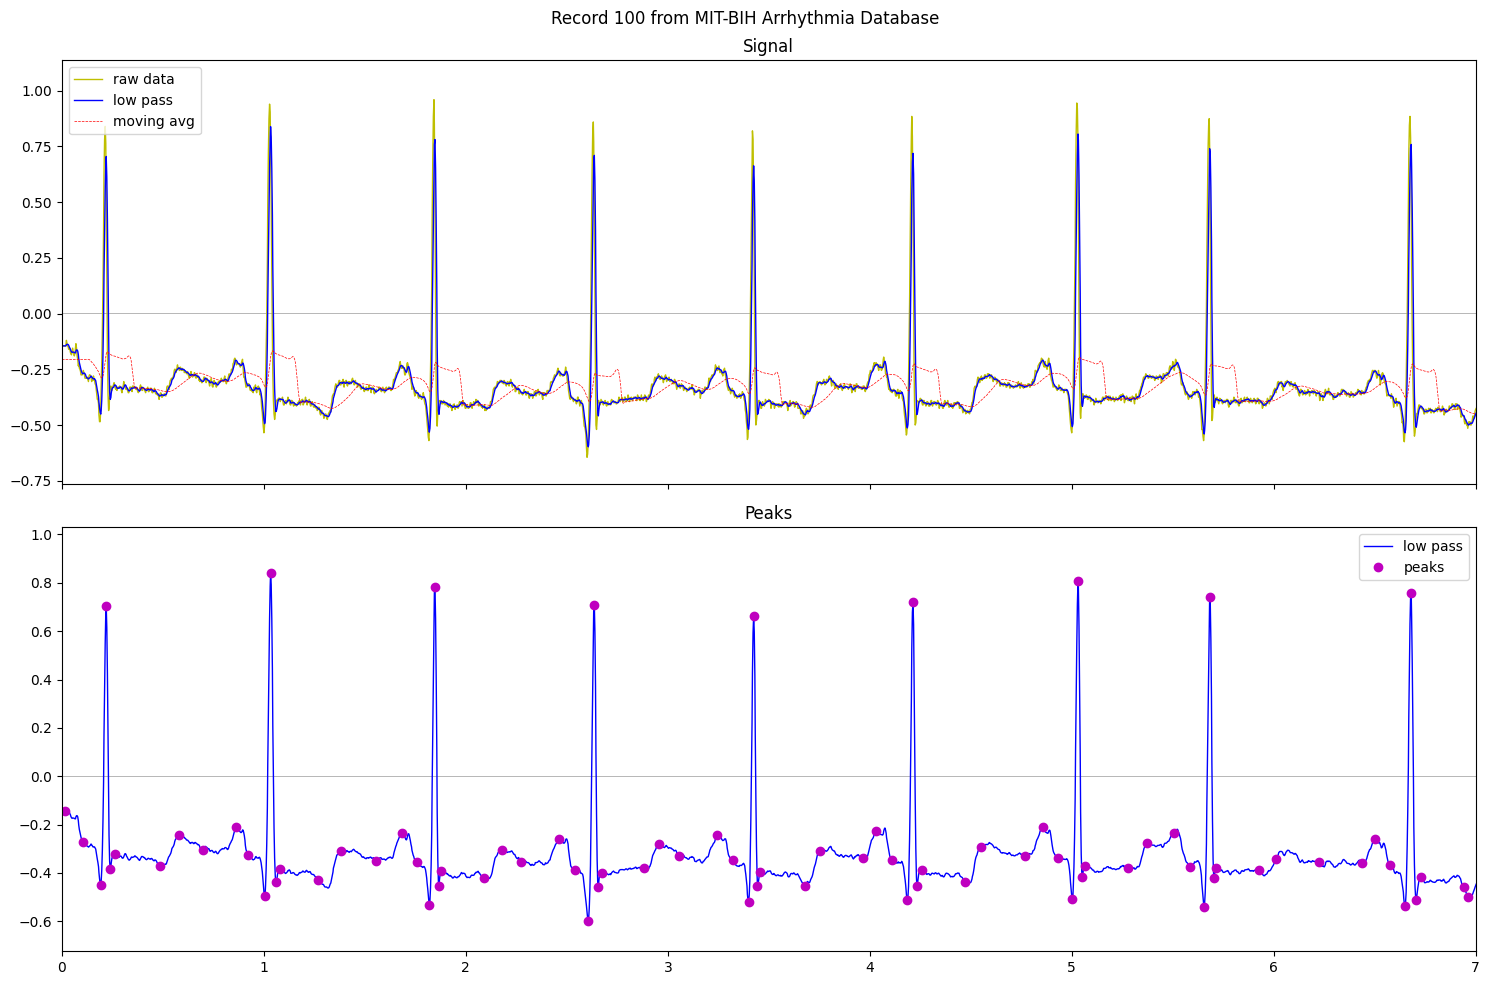

In [9]:
# Plotting window
X_MIN = 0.0
X_MAX = 7.0

# Create plots
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(15, 10)
fig.suptitle("Record 100 from MIT-BIH Arrhythmia Database")
axs[0].set_xlim(X_MIN, X_MAX)

# First plot
axs[0].title.set_text('Signal')
axs[0].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[0].plot(v_time, v_data, 'y' ,label="raw data", linewidth=1)
axs[0].plot(v_time, v_data_lp, 'b-', label="low pass", linewidth=1)
axs[0].plot(v_time, v_mean, 'r--', linewidth=0.5, label="moving avg")
axs[0].legend()

# Second plot
axs[1].title.set_text('Peaks')
axs[1].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[1].plot(v_time, v_data_lp, 'b-', label="low pass", linewidth=1)
axs[1].plot(v_peaks_time, v_peaks_data, 'mo', label="peaks")
axs[1].legend()

# Third plot
#axs[2].title.set_text('Peaks evenly spaced')
#axs[2].plot(v_time, axis_x, linewidth=0.2, color="black")
#axs[2].plot(v_time_even, v_peaks_data, 'mo-', label="peaks", linewidth=1)

plt.tight_layout()
plt.show()